In [2]:
import cv2
import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
# os.environ["CUDA_VISIBLE_DEVICES"]= "1"  # Set the GPU 2 to use

import torch
import numpy as np
import torch.nn.functional as F
import math
from torch import nn, optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import  TensorDataset, DataLoader
print(torch.cuda.is_available())
print(torch.__version__)

device = torch.device(4 if torch.cuda.is_available() else "cpu")

print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

import sys
import os
from pathlib import Path
# 현재 스크립트의 디렉토리를 가져옴
current_dir = Path(os.getcwd())
# my_project 디렉토리를 상위 디렉토리로 추가
parent_dir = os.path.abspath(os.path.join(current_dir, ".."))
sys.path.append(parent_dir)

import scipy.io
import cmath                
from skimage.metrics import structural_similarity as ssim
# import utills
from utils.common import *
from utils.fmri_utils_true import *

from torch.utils.tensorboard import SummaryWriter

# 기본 `log_dir` 은 "runs"이며, 여기서는 더 구체적으로 지정하였습니다
writer = SummaryWriter('runs/experiment1')
import nibabel as nib
from sklearn.linear_model import LinearRegression
import pydicom as dcm

import pandas as pd
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.glm.first_level import FirstLevelModel
from nilearn import plotting
from nilearn.image import concat_imgs, mean_img, resample_img
import nilearn

# from model.unet import *

True
1.11.0+cu113
Device: cuda:4
Current cuda device: 0
Count of using GPUs: 8


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ComplexConv(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True):
        super(ComplexConv,self).__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.padding = padding

        ## Model components
        self.conv_re = nn.Conv2d(in_channel, out_channel, kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias)
        self.conv_im = nn.Conv2d(in_channel, out_channel, kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias)
        
    def forward(self, x): # shpae of x : [batch,2,channel,axis1,axis2]
        real = self.conv_re(x[:,0]) - self.conv_im(x[:,1])
        imaginary = self.conv_re(x[:,1]) + self.conv_im(x[:,0])
        output = torch.stack((real,imaginary),dim=1)
        return output
        
#%%
if __name__ == "__main__":
    ## Random Tensor for Input
    ## shape : [batchsize,2,channel,axis1_size,axis2_size]
    ## Below dimensions are totally random
    x = torch.randn((10,2,3,100,100))
    
    # 1. Make ComplexConv Object
    ## (in_channel, out_channel, kernel_size) parameter is required
    complexConv = ComplexConv(3,10,(5,5))
    
    # 2. compute
    y = complexConv(x)

batchnorm=True
class UNet(nn.Module):
    def __init__(self, n_channels, out_ch, start_channel=64, alpha=1, bias=False, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.bilinear = bilinear
        # self.inc=nn.Conv2d(n_channels, 64, kernel_size=1, padding=0, bias=bias)
        self.inc = (DoubleConv(n_channels, start_channel, bias=bias))
        self.down1 = (Down(start_channel, start_channel*2, bias=bias))
        self.down2 = (Down(start_channel*2, start_channel*4, bias=bias))
        self.down3 = (Down(start_channel*4, start_channel*8, bias=bias))
        factor = 2 if bilinear else 1
        self.down4 = (Down(start_channel*8, start_channel*16 // factor, bias=bias))
        self.down5 = (Down(start_channel*16, start_channel*32 // factor, bias=bias))
        self.up1 = (Up(start_channel*32, start_channel*16, bilinear, bias=bias))
        self.up2 = (Up(start_channel*16, start_channel*8, bilinear, bias=bias))
        self.up3 = (Up(start_channel*8, start_channel*4 // factor, bilinear, bias=bias))
        self.up4 = (Up(start_channel*4, start_channel*2 // factor, bilinear, bias=bias))
        self.up5 = (Up(start_channel*2, start_channel // factor, bilinear, bias=bias))
        
        self.outc = (OutConv(start_channel, out_ch, bias=False))
        # self.outc = (DoubleConv(start_channel, out_ch, bias=bias))
        self.alpha=alpha
    def forward(self, x):
        temp=x
        x1 = self.inc(temp)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x6 = self.down5(x5)

        temp = self.up1(x6, x5)
        temp = self.up2(temp, x4)
        temp = self.up3(temp, x3)
        temp = self.up4(temp, x2)
        temp = self.up5(temp, x1)
        logits = self.outc(temp)+x
        return logits

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels,kernel_size=3, mid_channels=None,bias=False):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        if batchnorm==True:
            self.double_conv = nn.Sequential(
                nn.Conv2d(in_channels, mid_channels, kernel_size=kernel_size, padding=1, bias=bias),
                nn.BatchNorm2d(mid_channels),
                nn.PReLU(),
                nn.Conv2d(mid_channels, out_channels, kernel_size=kernel_size, padding=1, bias=bias),
                nn.BatchNorm2d(out_channels),
                nn.PReLU()
            )
        else:
            self.double_conv = nn.Sequential(
                nn.Conv2d(in_channels, mid_channels, kernel_size=kernel_size, padding=1, bias=bias),
                nn.PReLU(),
                nn.Conv2d(mid_channels, out_channels, kernel_size=kernel_size, padding=1, bias=bias),
                nn.PReLU()
            )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels, bias=False):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, 2, stride=2, padding=0, bias=bias),
            DoubleConv(in_channels, out_channels, bias=bias)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=False, bias=False):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2, bias=bias)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2, bias=False)
            self.conv = DoubleConv(in_channels, out_channels, bias=bias)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels, bias=False):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1,bias=bias)

    def forward(self, x):
        return self.conv(x)

GE epi에서 SE epi로 가는 모델. 데이터는 하나로 오버피팅

(128, 128, 56)
(128, 128, 56, 188)
(128, 128, 56)


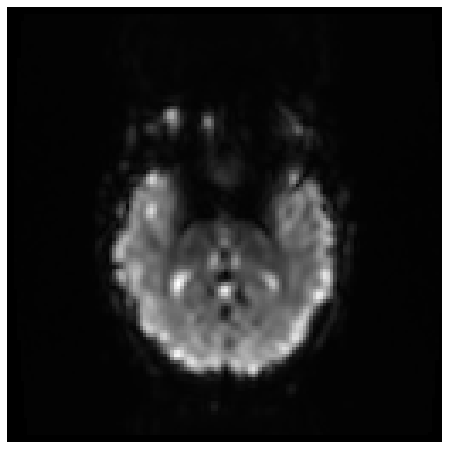

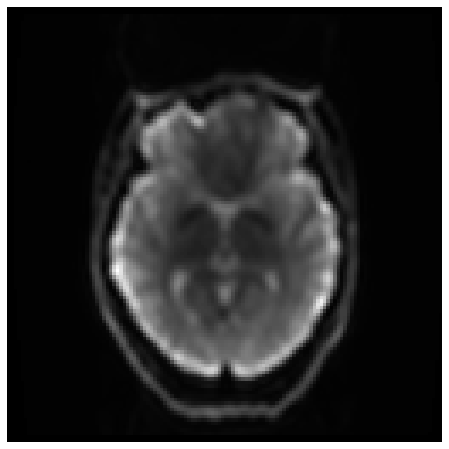

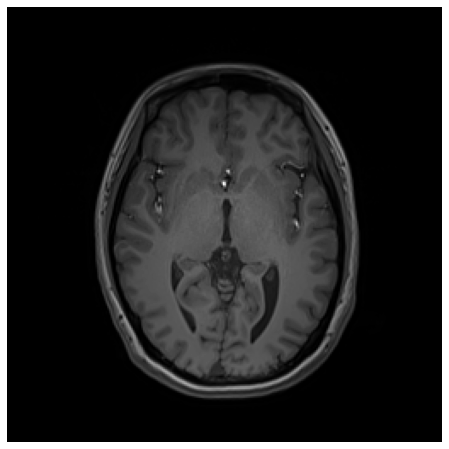

(6, 128, 128)


In [4]:
mod_num = 160
mask=False
slice_num=25  # 13이었음
coordinate=[(68,25),(73,100)]
center_slice=104
slice_num=24
AP_cor=nib.load('/home/milab/SSD_8TB/LeeSooHyung/datasets/fmri_inhomo_test_2/2024.12.28/Emotion/TE_60/se_emo_mb4_tr2000_te60_AP.nii')
GE_39ms=nib.load('/home/milab/SSD_8TB/LeeSooHyung/datasets/fmri_inhomo_test_2/2024.12.28/Emotion/TE_60/gre_emo_mb4_tr2000_te60.nii').get_fdata()[:,:,:]
mprage=nib.load('/home/milab/SSD_8TB/LeeSooHyung/datasets/fmri_inhomo_test_2/2024.06.04/t1_mprage_tra_p2_iso.nii').get_fdata()[:,:,center_slice-81:center_slice+81]

AP_cor_phase=nib.load('/home/milab/SSD_8TB/LeeSooHyung/datasets/fmri_inhomo_test/2024.01.29.KDW/regular/SE_EPI_AP_RR_phase.nii')

# AP=nib.load('/home/milab/SSD_8TB/LeeSooHyung/datasets/fmri_inhomo_test/2023.12.14.KDWook/SE_EPI_AP.nii').get_fdata()[:,:,1:]
# AP_SE=nib.load('/home/milab/SSD_8TB/LeeSooHyung/datasets/fmri_inhomo_test/JSYun/SE_EPI_AP.nii')
AP_mask_sliced=make_mask_sliced_direct(AP_cor,slice_num)
if mask==False:
    AP_mask_sliced=copy_nii_header(np.ones(AP_mask_sliced.get_fdata().shape),AP_mask_sliced)

GE_39ms_phase=nib.load('/home/milab/SSD_8TB/LeeSooHyung/datasets/fmri_inhomo_test/2024.01.29.KDW/regular/Visual_TR_2_true_RR_phase.nii').get_fdata()[:,:,:]
GE_39ms_phase_normed=GE_39ms_phase/4096*math.pi

# GE_39ms=nib.load('/home/milab/SSD_8TB/LeeSooHyung/datasets/fmri invivo test_KJJ_motor/MF20230529204255DST1312211075993-0005-00001-000001.nii')
# AP=nib.load('/home/milab/SSD_8TB/LeeSooHyung/datasets/fmri_inhomo_test/JSYun/AP.nii')
# print(AP_cor)
SE_EPI=np.average(AP_cor.get_fdata()[:,:,:],axis=3)
SE_EPI_phase=AP_cor_phase.get_fdata()[:,:,1:]/4096*math.pi
SE_EPI_original=SE_EPI
print(SE_EPI.shape)
# print(SE_EPI_phase.shape)
print(GE_39ms.shape)
# print(GE_39ms_phase.shape)
# SE_EPI=AP_SE.get_fdata()[:,:,1:]
GE_EPI=GE_39ms
# GE_EPI_complex=GE_39ms.astype(complex)*np.exp(1j * GE_39ms_phase_normed[:,:,:,:])
# GE_EPI=GE_EPI_complex

# SE_EPI_complex=SE_EPI.astype(complex)*np.exp(1j * SE_EPI_phase)
# SE_EPI=SE_EPI_complex
# AP_EPI=AP.get_fdata()[:,:,1:]
GE_EPI_avg=0
for i in range(16):
    GE_EPI_avg=GE_EPI_avg+GE_EPI[:,:,:,i]
GE_EPI_avg=GE_EPI_avg/16
print(GE_EPI_avg.shape)

# fig,axes=plt.subplots(nrows=2,ncols=4,figsize=(24,12))
# axes[0, 0].set_ylabel('GE-EPI', fontsize=50)
# axes[0, 0].set_title("None smoothed", fontsize=50)
# # axes[0, 0].axis('off')
# axes[0, 1].set_title("FWHM = 3", fontsize=50)
# axes[0, 1].axis('off')
# axes[0, 2].set_title("FWHM = 6", fontsize=50)
# # axes[0, 2].axis('off')
# axes[0, 3].set_title("MPRAGE structure-1", fontsize=50)
# # axes[0, 3].axis('off')

# axes[1, 0].set_ylabel('Proccessed', fontsize=50)
# # axes[1, 0].set_title("GE-EPI structure")
# # axes[1, 0].axis('off') 
# # axes[1, 1].set_title("SE-EPI structure")
# # axes[1, 1].axis('off')
# # axes[1, 2].set_title("MPRAGE structure")
# # axes[1, 2].axis('off')
# # axes[0, 3].set_title("MPRAGE structure")
# # axes[1, 3].axis('off')
# # fig.tight_layout()

# for ax in axes.flatten():
#     ax.xaxis.set_visible(False)
#     # make spines (the box) invisible
#     plt.setp(ax.spines.values(), visible=False)
#     # remove ticks and labels for the left axis
#     ax.tick_params(left=False, labelleft=False)
#     #remove background patch (only needed for non-white background)
#     ax.patch.set_visible(False)  

# fig.show()
# # x축 레이블 설정
# plt.tight_layout()  # subplot 간 간격 조절
# plt.show()
            

check_img(GE_EPI_avg[:,:,slice_num],cbar=False,norm=True,rotate=True)
check_img(SE_EPI[:,:,slice_num],cbar=False,norm=True,rotate=True)
check_img(mprage[:,:,slice_num*3],cbar=False,norm=True,rotate=True)

# check_img(AP_EPI[:,:,slice_num],cbar=False,norm=True)
SE_EPI=SE_EPI[:,:,slice_num]
GE_EPI=GE_EPI_avg[:,:,slice_num]
SE_list=[]
GE_list=[]
for i in range(6):
    SE_list.append(SE_EPI)
    GE_list.append(GE_EPI)
SE_EPI=np.stack(SE_list)
GE_EPI=np.stack(GE_list)
print(SE_EPI.shape)
# check_img(AP_mask_sliced.get_fdata())


In [5]:
array_input=torch.tensor(GE_EPI,dtype=torch.cfloat)
array_label=torch.tensor(SE_EPI,dtype=torch.cfloat)

print(GE_EPI.dtype)
print(SE_EPI.dtype)

aug_input=data_aug_flip(array_input,[1])
aug_label=data_aug_flip(array_label,[1])
aug_input=data_aug_flip(aug_input,[0])
aug_label=data_aug_flip(aug_label,[0])

train_input=torch.unsqueeze(array_input[:,:,:],dim=1)
train_label=torch.unsqueeze(array_label[:,:,:],dim=1)

test=GE_39ms[:,:,slice_num,10:]
# test=GE_EPI_complex[:,:,slice_num,30:]
print(GE_39ms.shape)
print(test.shape)
invivo_input=torch.permute(torch.unsqueeze(torch.tensor(test),dim=2),(3,2,0,1)).cfloat()

float64
float64
(128, 128, 56, 188)
(128, 128, 178)


In [6]:
n=4
torch.manual_seed(4) #4는 완전 망가진 시그널

# print(add_noise(torch.tensor(GE_EPI[0,:,:]),0.00001,True,True))
print(train_input.shape)
dataset_2ch=TensorDataset(train_input
                         ,train_label
                         )
self2self=TensorDataset(train_input
                         ,train_input
                         )
invivo=TensorDataset(invivo_input,
                     invivo_input)
# dataset_2ch_test=testset_for_bold(GE_EPI[0,:,:],SE_EPI[0,:,:],coordinate[0],coordinate[1],n,1,'rect',std=3,noise=0.000012,mask=None) #0.000012

torch.Size([6, 1, 128, 128])


In [7]:
traindataset=DataLoader(dataset_2ch, batch_size=1, shuffle=True)
valdataset=DataLoader(dataset_2ch, batch_size=1, shuffle=True)
selfdataset=DataLoader(self2self, batch_size=6, shuffle=True)
# testdataset=DataLoader(dataset_2ch_test, batch_size=1, shuffle=False)
invivodataset=DataLoader(invivo, batch_size=1, shuffle=False)

torch.Size([178, 1, 1, 128, 128])
torch.Size([128, 128, 1, 178])
(128, 128, 1, 178)


/home/milab/anaconda3/envs/LSH_base/lib/python3.8/site-packages/nilearn/glm/first_level/first_level.py:707: UserWarning: Mean values of 0 observed. The data have probably been centered.Scaling might not work as expected
  Y, _ = mean_scaling(Y, self.signal_scaling)
/home/milab/anaconda3/envs/LSH_base/lib/python3.8/site-packages/nilearn/glm/first_level/first_level.py:707: UserWarning: Mean values of 0 observed. The data have probably been centered.Scaling might not work as expected
  Y, _ = mean_scaling(Y, self.signal_scaling)


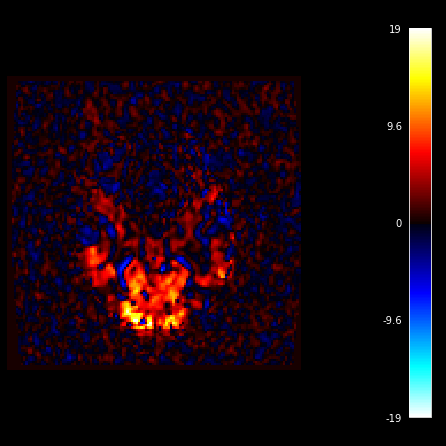

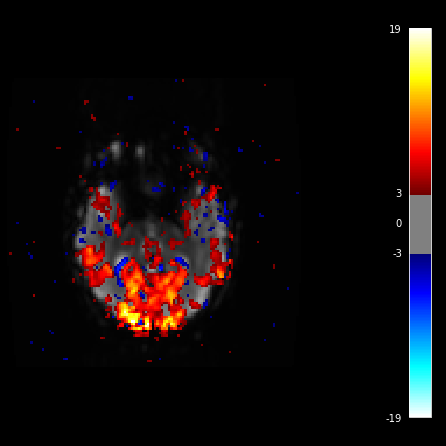

In [10]:
bold_no_pre=dataset_to_tensor(invivodataset)
print(bold_no_pre.shape)
bold_no_pre=torch.unsqueeze(torch.permute(torch.squeeze(torch.abs(bold_no_pre)),(1,2,0)),2)
print(bold_no_pre.shape)
print(bold_no_pre.numpy().shape)
data=nib.Nifti1Image(bold_no_pre.numpy(),affine=np.eye(4))
# data=nilearn.image.smooth_img(data,3)
z_map,dummy_data=calculate_glm_emotion(data,AP_mask_sliced,threshold=0,masking=False, colorbar=True,mod=178)
z_map,dummy_data=calculate_glm_emotion(data,AP_mask_sliced,threshold=3,masking=False, colorbar=True,mod=178)

# glm_calculation(bold_no_pre,n,95,gauss_2d=1,gauss_1d=1,mask=AP_mask,rect=True)
# image_plot=bold_no_pre[coordinate[1],coordinate[0],0,:]
nib.save(dummy_data,'kdw_data_2')
# image_plot=gaussian_filter(image_plot,2)
# list=gaussian_filter1d(image_plot,1)
# plt.plot(list)

In [11]:
model_1=UNet(2,2,start_channel=32) #need deeper padding unet?
# model_1=ResDnCNN(channels=2,features=64, out_ch=2, num_of_layers=64,bias=False,bn=False)
# model_1=ResDnCNN_wo_act(channels=2,features= 32, out_ch=2, num_of_layers=64,bias=False,bn=False)
# model=VGG(channels=2,features=16,out_ch=2,kernel_size=30,num_of_layers=3)
# model=dfnet(kernel_size=30,features=16,num_of_layers=10,bias=False,bn=True)
# model=deconvfilter(128)
# model_1.apply(weight_init_xavier_uniform)

In [14]:
epoch=100
torch.cuda.empty_cache()
torch.cuda.memory_summary
model_1=model_1.to(device)

loss_function_k=torch.nn.L1Loss()
# loss_function_k=ComplexL1()
optimizer_1=optim.AdamW(model_1.parameters(), lr=0.001, weight_decay=0)
# optimizer=optim.SGD(model.parameters(), lr=0.001, weight_decay=2)
scheduler=optim.lr_scheduler.StepLR(optimizer_1,100,gamma=0.8)
# scheduler=optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0.0001)
loss_function_img=torch.nn.MSELoss()
norm_scale=15000

/home/milab/anaconda3/envs/LSH_base/lib/python3.8/site-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


epoch: 99, val_avg_ssim: 0.9998336665568603


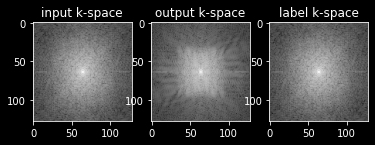

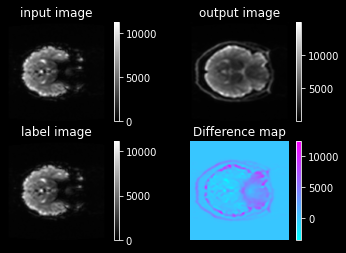

SSIM Accuracy of the network on the images: 0.703892058268925 %


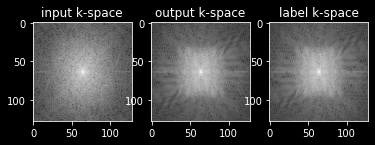

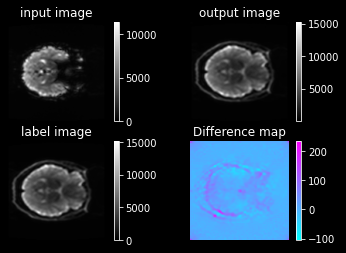

SSIM Accuracy of the network on the images: 0.9998336665568603 %


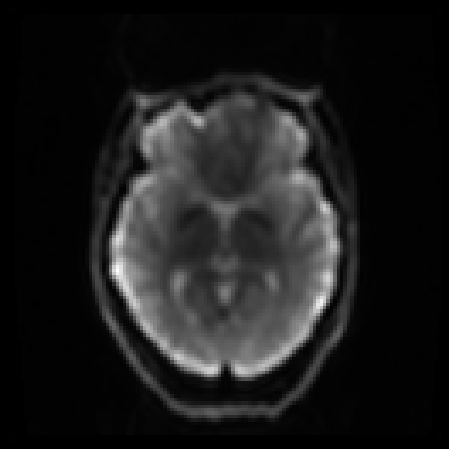

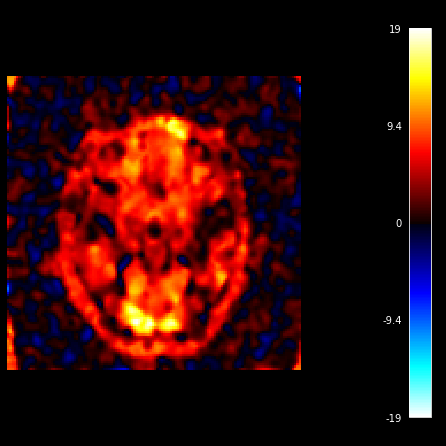

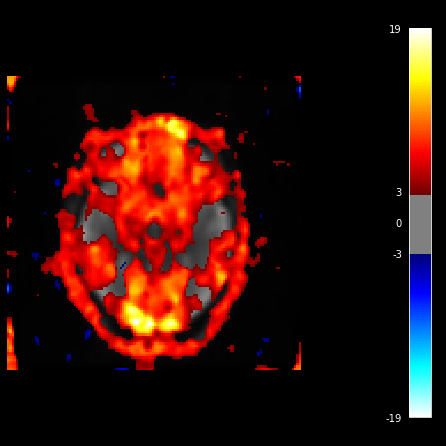

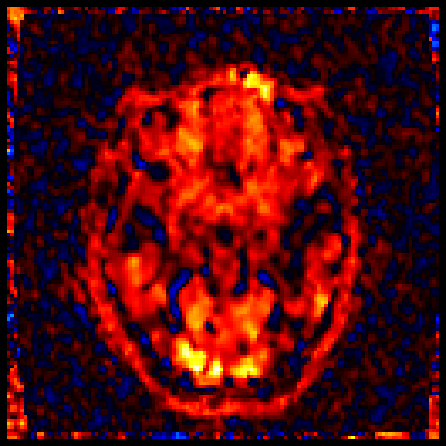

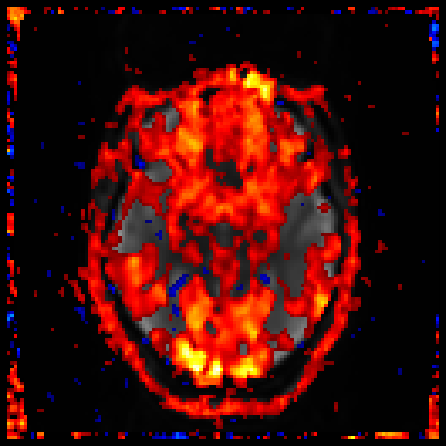

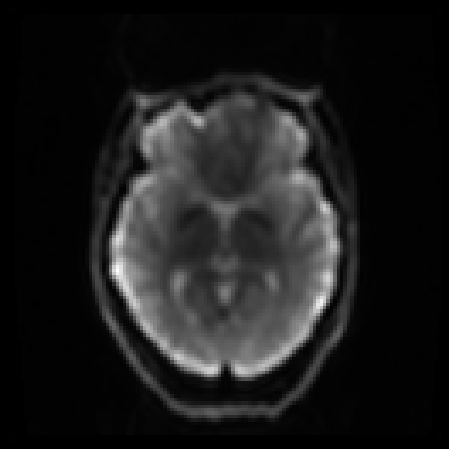

In [15]:

#train
#input = traindataset[train_X, train_Y]
#output = {fig, pandas;val_accuracy, train_loss}
check_num=100
avg_ssim_list_train=[]
# with torch.autograd.set_detect_anomaly(True):
i=0
for i in range(epoch):
    
    total, total_loss = train_model(model_1, traindataset, optimizer_1, loss_function_k, loss_function_img, device, norm_scale, writer, epoch_number=i,noise=None, frequency_loss=True, image_loss=False,l1norm=None,tv_loss=None)
    #0.000012 3000000
    
    # writer.add_scalar('Frequency domain loss', total_loss/total,i)

    scheduler.step()

    total, total_ssim=eval_model(model_1, valdataset, optimizer_1, loss_function_k, loss_function_img, device, norm_scale, writer, epoch_number=i, k_plot=False, img_plot=False, print_ssim=False)
    
    avg_ssim_list_train.append(total_ssim/total)
    # print(f'epoch: {i}, val_avg_ssim: {total_ssim/total}')
    
    if i%check_num==check_num-1:
        print(f'epoch: {i}, val_avg_ssim: {total_ssim/total}')
        total, total_ssim=eval_model(model_1, invivodataset, optimizer_1, loss_function_k, loss_function_img, device, norm_scale, writer, epoch_number=i, k_plot=True, img_plot=True, print_ssim=True)
        total, total_ssim=eval_model(model_1, valdataset, optimizer_1, loss_function_k, loss_function_img, device, norm_scale, writer, epoch_number=i, k_plot=True, img_plot=True, print_ssim=True)
        bold=testset_output(model_1,invivodataset,device,norm_scale)
        bold_per=torch.abs(torch.unsqueeze(torch.permute(bold,(1,2,0)),2).cfloat())
        check_img(bold_per[:,:,0,0].numpy(),cbar=False,norm=True,rotate=True)
        # check_signal(model_1,coordinate,testdataset,device,norm_scale,gaussian_blur_2d=1,gaussian_blur_1d=1)
        # check_signal(model,coordinate,testdataset,device,norm_scale,1)
        # check_signal(model_1,[30,64],testdataset,device,norm_scale,gaussian_blur_2d=1,gaussian_blur_1d=1)
        # glm_calculation(bold_per,n,99,gauss_2d=2,gauss_1d=1,mask=AP_mask)
        z_map,data=calculate_glm_emotion(nilearn.image.smooth_img(nib.Nifti1Image(bold_per.numpy(),affine=np.eye(4)),3),AP_mask_sliced,threshold=0,colorbar=True,mod=178)
        z_map,data=calculate_glm_emotion(nilearn.image.smooth_img(nib.Nifti1Image(bold_per.numpy(),affine=np.eye(4)),3),AP_mask_sliced,threshold=3,colorbar=True,mod=178)
        z_map,data=calculate_glm_emotion(nib.Nifti1Image(bold_per.numpy(),affine=np.eye(4)),AP_mask_sliced,threshold=0,colorbar=False,mod=178)
        z_map,data=calculate_glm_emotion(nib.Nifti1Image(bold_per.numpy(),affine=np.eye(4)),AP_mask_sliced,threshold=3,colorbar=False,mod=178)
        # nib.save(z_map,'z_map')
        nib.save(data,'kdw_data_1')
        plt.show()
        check_img(bold_per[:,:,0,0].numpy(),cbar=False,norm=True,rotate=True)
        


In [ ]:
half=z_map.get_fdata()[:,64:]
print(half.shape)
check_img(half)
print(np.max(half))
print(np.where(half>=5))
tuple_1=np.where(half>=5)
print(tuple_1[1][32])
data.get_fdata()[:,64:].shape
data_1=data.get_fdata()[:,64:]
coordinate=[68,28]
plt.plot(data_1[coordinate[0],coordinate[1],0])
plt.show()

back=0
for i in range(-1,1,1):
    for j in range(-1,1,1):
        back+=data_1[coordinate[0]+i,coordinate[1]+j,0]
plt.plot(back)
plt.show()

back_1=scipy.ndimage.gaussian_filter1d(back, 1)
plt.plot(back_1)
plt.show()
back_2=scipy.ndimage.gaussian_filter1d(back, 2)
plt.plot(back_2)
plt.show()

In [ ]:
check_img(z_map.get_fdata(),cmap='autumn')

In [ ]:
plt.plot(create_design_matrix(2,178).values[:,0])